<a href="https://colab.research.google.com/github/Jamie3099/JamieGISWork/blob/master/6_pysal_weights_moran_lisaJamienew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Working with Pysal on Weights, Moran and Lisa: Spatial Statistical Analysis**#

In this exercise we're going to get into some key spatial statistics. So far in this course we've mostly been visualising spatial distributions and patterns. Here we will run statistical tests to determine whether nor not a pattern or spatial structure exists, and to test what kind of pattern (dispersed vs. random vs. clustered) is present.

This kind of analysis is what we would call **spatial statistical analysis**. This is different from ** deterministic analysis** -which is when you analyse things like which polygons intersect one another in a dataset, and which polygons entirely contain other polygons.  **Spatial statistical analysis** is a subset of **probabilistic analysis** - which is simply analysis of how likely it is that something happened. In this exercise we will start by working with vector-based data (points, lines and polygons). Then we will briefly look at working with raster datasets.



### Let's get started...####  
<font color='orangered'> ~ déjà vu ~</font> 
* Make your own copy of this notebook;
* Get your tools... you know install and import your libraries...
* Remember to hit play or type 'Ctrl'+'Enter' to run the code in any cell (grey shaded cells in the page) to make things happen!

Remember that broken thing two weeks ago? Yep, still broken... hence the long list of imported libraries.


In [1]:
##codecell_Spatial_Statistical_Analysis_ImportUrLibraries

# start by installing tools as usual
!pip install geopandas
!pip install descartes
!pip install mapclassify
!pip install pysal

#@title
!apt-get install -qq curl g++ make
#@title
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
#@title
import os
os.chdir('spatialindex-src-1.8.5')
#@title
!./configure
#@title
!make
#@title
!make install
#@title
!pip install rtree
#@title
!ldconfig
#Working through the example at http://toblerity.org/rtree/examples.html
#@title
from rtree import index
from rtree.index import Rtree
#@title
p = index.Property()
idx = index.Index(properties=p)
idx

     |████████████████████████████████| 921kB 2.8MB/s 
     |████████████████████████████████| 10.1MB 53.4MB/s 
     |████████████████████████████████| 11.8MB 200kB/s 
  Created wheel for mapclassify: filename=mapclassify-2.1.1-cp36-none-any.whl size=29001 sha256=3b47e8f95a163acd941102b9adc3069ce602ab3fd1648a802b6f42c6d5d32795
  Stored in directory: /root/.cache/pip/wheels/fc/b8/58/56b650743289cbecb476ef1fc50ab0aeaa0b12e56ad912d624
Successfully built mapclassify
     |████████████████████████████████| 25.0MB 93kB/s 
  Created wheel for pysal: filename=pysal-2.1.0-py2.py3-none-any.whl size=25330028 sha256=0bdd44c43a31a053cb2f74395b114ed4806b051ebbbb1b64d17841760adcd8e3
  Stored in directory: /root/.cache/pip/wheels/d3/83/3d/697615f4ce74486679f237d1d6a1cf70cd742fa6a34baba744
Successfully built pysal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0  

In [2]:
##codecell_Spatial_Statistical_Analysis_ImportUrLibraries


#and importing tools...
import geopandas as gpd 
import requests 
import zipfile
import io
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import pandas as pd 
import pysal as ps
import numpy as np


/usr/local/lib/python3.6/dist-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


 **Learning a new language – decomposing the code** 
  <br>
  in ##codecell_Spatial_Statistical_Analysis_ImportUrLibraries. These are what we call **prerequisites**. You know by now that they are basic tools so you can get started.
* *Pandas* lets you manipulate your data. <font color='orangered'> ~ déjà vu ~</font>
* *Geo-pandas* lets you manipulate your geographic data. <font color='orangered'> ~ déjà vu ~</font>
* *requests* lets you access easily Hypertext Transfer Protocol or [HTTP](https://www.w3schools.com/tags/ref_httpmethods.asp) library ([doc.](https://realpython.com/python-requests/)).
* *zipfile* lets you reate, read, write, append, and list a ZIP file.<font color='orangered'> ~ déjà vu ~</font>
* *io* (input/open) lets you to access files and streams (a stream is sequence of data elements made available over time - processed 1 at a time)<font color='orangered'> ~ déjà vu ~</font>
* *matplotlib* lets you plot in 2D which extensive plotting library for quality publication & *matplotlib.pyplot* provides a MATLAB-like way of plotting <font color='orangered'> ~ déjà vu ~</font>
* *seaborn* lets you do statitistical data visualisation.<font color='orangered'> ~ déjà vu ~</font>
* *numpy* lets you do statistics especially statistics using numpy.<font color='orangered'> ~ déjà vu ~</font>
* *pysal* <font color='orangered'> ~ déjà vu ~</font> we have use it before in lab4_SpatialPatterns. This is the one I'd like you to spend a bit more time with...Why? because this library is used to conduct exploratory spatial data analysis. You can have a look at its [documentation](https://pysal.readthedocs.io/en/v1.11.0/users/introduction.html), a [video]((https://www.youtube.com/watch?v=FN1nH4Fkd_Y)) of one of its creator  and high level applications for spatial analysis (see image below).
<div>
<img src="https://sergerey.org/images/pysal.png" width="800"/>
</div>


##**Preparing your Data**##

You likely have realised by now that the most time consuming part of your work is preparing your data ... Data preparation is important, and your ability to use or re-use a dataset depends on how well it has been prepared.  When you are selecting and preparing your data, remember to think about your research aims and the questions you are trying to answer, and make sure your data is set up to respond to those aims and questions.

The following scripts repeat what you have done in previous practicals, in particular Lab4_spatial_patterns_in_excavation where you complete the following basic steps:
* import
* read
* select/extract
* merge 

In [3]:
##codecell_Spatial_Statistical_Analysis_ImportOurData

# And now, as usual, get the data
url = 'https://github.com/ropitz/spatialarchaeology/blob/master/gabii_spatial.zip?raw=true'
local_path = 'temp/'

print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")

#here this is very much like what we are doing on your PC file system
z.extractall(path=local_path) # extract to folder

#here we want to download the shapefiles
# so we sort them using sorted()
#so we have a comprehensive list of all variables available in our dataset
# print them
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

#here you know it ...
#we use function read() to access the data from this notebook and work with it
dbf, shp, shx = [filename for filename in filenames]
gabii = gpd.read_file(local_path + 'gabii_SU_poly.shp')

Done
['gabii_SU_poly.dbf', 'gabii_SU_poly.shp', 'gabii_SU_poly.shx']


In [4]:
##codecell_Spatial_Statistical_Analysis_Peek@OurData

# As you've done before, print out some information on the data 
# To check the number of records in the file, so it has loaded in ok
# And preview the data 
print("Shape of the dataframe: {}".format(gabii.shape))
print("Projection of dataframe: {}".format(gabii.crs))
gabii.tail() #last 5 records in dataframe

Shape of the dataframe: (6774, 11)
Projection of dataframe: {}


,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry
6769,BOT,{71AF9B12-2F06-495C-83E5-0FAA360F8F4A},0.0,None,None,7258,0,0,2.678564,0.499149,"POLYGON Z ((2330859.598 4639809.998 58.475, 23..."
6770,PV,{0ACC8266-B607-4C90-80BC-CAA66B641158},0.0,basalt pavement,None,7259,0,0,1.884223,-0.011060,"POLYGON Z ((2330859.928 4639810.684 59.054, 23..."
6771,PV,{04AAFA17-1C2C-48DC-8D98-3F159C9594ED},0.0,road preparation,None,7260,0,0,4.340378,-0.315862,"POLYGON Z ((2330859.690 4639810.676 59.299, 23..."
6772,DEP,{29409DA1-5E72-4C40-B9EB-DF30BDA4AB99},0.0,surface,None,7244,0,0,3.931959,0.684395,"POLYGON Z ((2330858.600 4639808.870 59.492, 23..."
6773,FEAT,{800479EB-554B-4180-85C5-91DA0FE8C762},0.0,bedrock,None,7255,0,0,3.960617,-0.958252,"POLYGON Z ((2330859.137 4639808.867 58.846, 23..."


In [5]:
##codecell_Spatial_Statistical_Analysis_ObjectType&SU

# As we've done before (returning to the Gabii finds data - see ###codecell_SpatialPatterns_WhichTypeOfSpecialFinds&fromWhere?) 
# Get the non-spatial special finds data
# And they are archived per SU /Stratigraphical Unit
sf_su = pd.read_csv("https://raw.githubusercontent.com/ropitz/gabii_experiments/master/spf_SU.csv")
sf_su.head()

,SU,SF_ID,SF_DESCRIPTION,SF_OBJECT_TYPE
0,0,1,coin,Coin
1,0,15,coin,Coin
2,0,18,coin,Coin
3,0,80,ceramic fragment,Ceramic Fragment
4,0,82,fish hook,NaN


In [6]:
##codecell_Spatial_Statistical_Analysis_FindsBecomesSpatial

#Then let's combine our polygons representing context shape and location
# with the special finds data
# We can use known command  'merge()' for this (see especially explanation for this in #codecell_Webmaps&Distributions_MergingZeData and also ###codecell_SpatialPatterns_TextileToolsBecomesSpatial)

gabii_textools = gabii.merge(sf_su, on='SU')
gabii_textools.head()

,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry,SF_ID,SF_DESCRIPTION,SF_OBJECT_TYPE
0,DEP,{7547F186-D2C4-421D-A91C-330DE54C991A},0.0,None,None,1376,0,0,4.234191,0.867656,"POLYGON Z ((2330811.445 4639824.504 62.386, 23...",297,ring,Ring
1,DEP,{7547F186-D2C4-421D-A91C-330DE54C991A},0.0,None,None,1376,0,0,4.234191,0.867656,"POLYGON Z ((2330811.445 4639824.504 62.386, 23...",305,nail,NaN
2,DEP,{9749D670-DB74-425F-A059-9AA7C4DDB408},0.0,None,None,1375,0,0,4.282142,0.886152,"POLYGON Z ((2330811.441 4639824.495 62.385, 23...",300,stamp,NaN
3,DEP,{9749D670-DB74-425F-A059-9AA7C4DDB408},0.0,None,None,1375,0,0,4.282142,0.886152,"POLYGON Z ((2330811.441 4639824.495 62.385, 23...",398,stamp,NaN
4,DEP,{33BC7316-B87A-4FAD-B117-043B1B72927E},0.0,None,None,2258,0,0,33.824963,42.657425,"POLYGON Z ((2330865.519 4639860.941 61.348, 23...",320,Bone knob head hairpin,Pin


In [7]:
##codecell_WorkingWithPysal_DataPreparation

#Let's pull all those find types out of the big list. 
#These commands should look familiar because you've done them before (###codecell_SpatialPatterns_SpecialFindsSelection)
types = ['Loom Weight','Spool','Spindle Whorl']
textile_tools = gabii_textools.loc[gabii_textools['SF_OBJECT_TYPE'].isin(types)]

# Now let's count up how many of these tools appear in each context (SU).
# This command will print out a list of the number of textile tools in each SU next to that SU number.
textile_tool_counts = textile_tools.groupby('SU')['SF_OBJECT_TYPE'].value_counts().unstack().fillna(0)


gts = gabii_textools.merge(textile_tool_counts, on='SU')
gts_new = gts.drop_duplicates(subset="SU")
gts_new.head()

,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry,SF_ID,SF_DESCRIPTION,SF_OBJECT_TYPE,Loom Weight,Spindle Whorl,Spool
0,DEP,{33BC7316-B87A-4FAD-B117-043B1B72927E},0.0,None,None,2258,0,0,33.824963,42.657425,"POLYGON Z ((2330865.519 4639860.941 61.348, 23...",320,Bone knob head hairpin,Pin,0.0,0.0,1.0
4,DEP,{9322E5A4-3B71-4E18-A8D3-61067000D37A},0.0,survey innacuracy circa 4cm,None,516,0,0,29.108417,24.196861,"POLYGON Z ((2330791.518 4639855.147 64.693, 23...",261,spool,Spool,1.0,0.0,1.0
6,DEP,{14B94C91-950D-4F3F-8CB0-A3D3CF196FCE},0.0,None,None,587,0,0,31.845889,35.011648,"POLYGON Z ((2330786.540 4639851.471 64.633, 23...",262,loom weight,Loom Weight,1.0,0.0,0.0
8,DEP,{34DFB891-ECF7-477A-939D-87491FA05165},0.0,None,None,1306,0,0,26.189290,11.969015,"POLYGON Z ((2330807.058 4639840.405 63.413, 23...",281,complete vessel,Votive,0.0,0.0,1.0
11,DEP,{9CBC09F7-DBBF-4F8E-A6F9-278240E34672},0.0,None,None,1327,0,0,39.322690,67.846039,"POLYGON Z ((2330807.254 4639825.210 63.122, 23...",287,gaming piece - die,Game Piece,1.0,0.0,0.0


##**Visualising your Data**##
Now plot your data to visualise it with a focus on the Spool Distribution of Gabii excavations. 

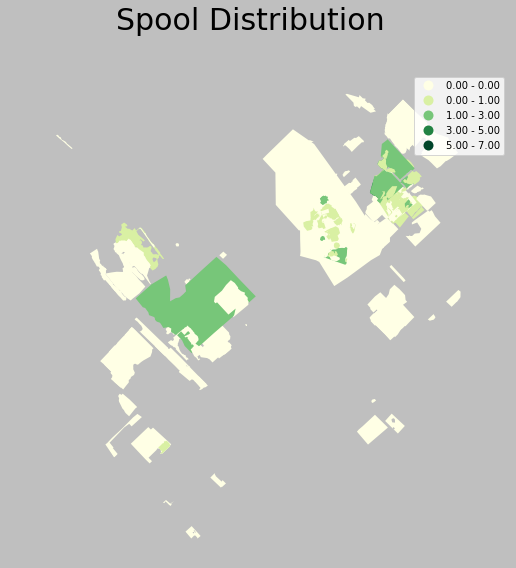

In [8]:
##codecell_Spatial_Statistical_Analysis_PlotZeData

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot SUs
#gabii.plot(ax=ax, facecolor='0.85', linewidth=0)

# Quantile choropleth of deaths at the street level
gts_new.plot(column='Spool', scheme='fisher_jenks', ax=ax, \
        cmap='YlGn', legend=True, linewidth=3)
# Plot pumps
#xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
#ax.scatter(xys[:, 0], xys[:, 1], marker='^', color='k', s=50)
# Remove axis frame, also called graticule
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Keep axes (your x and y) proportionate
plt.axis('equal')
# Title 
# f.suptitle()command allows you to add a centered title to the figure
f.suptitle('Spool Distribution', size=30)
# Draw
plt.show()

---------------------
####**Visualisation**####

They are different ways to visualise your variables. The best way to visually represent your data broadly depends on the type data present. Basic data types are:

> data type | | | | |
> ---|---|---|---|---
> | Nominal|Qualitative ||
> | Ordinal| Ranked |
> |Numerical| Quantitative||

>>>> <img src="http://article.sapub.org/image/10.5923.j.ajgis.20170601.02_002.gif" width="500"/> </div> 

In general, the image below provides a guide to good practice for visually representing different types of data as follows:

* **qualitative data** :*Change of form, of pattern, of texture, of orientation, of hue*
* **rank or ordering data** : *Variation in dimension, in colour or pattern strength lightness*
* **quantitative data** :*Change in dimension, in lightness*




<img src="http://article.sapub.org/image/10.5923.j.ajgis.20170601.02_003.gif" width="700"/>
</div>



---------------------



##**Spatial Statistical Analysis**##

So far, you've (rapidly) repeated the steps you've done in a previous exercise to visualise a spatial pattern - this time of the spools discovered while excavating at Gabii. 

Now how do you statistically test if there is a pattern? Statistical tests are needed when it is not obvious from just looking at the distribution whether or not a pattern exists. We can start with some of the more basic tests: **Moran's** and **local Moran's**, which are tests for spatial autocorrelation. Moran's I statistic (1948, 1950) is one of the classic (as well as one of the most common) ways of measuring the degree of spatial autocorrelation in data. 

**But how does this work? ** You have seen that objects in space are rarely randomly distributed. In fact, they usually have some degree of patchiness (i.e., they are spatially clustered) which can produce a variety of distinct spatial patterns. <br> These patterns can be quantified according to the degree of similarity between the attributes values of adjacent spatial objects (polygons, lines, points, raster cells). <br>Start by testing  if  nearby  objects  tend  to  have  similar  attributes  (Figure  below(a))  than expected from a random distribution (Figure 6.1(b)). 
      


<div> <img src="https://raw.githubusercontent.com/Francoz-Charlotte/Spatial_teaching_CFediting/master/Untitled.png" width="700"/> </div>

The degree to which similar values cluster together spatially is the degree of autocorrelation. This value is reported as **Moran's I**.

Spatial  statistics  assume  that,  within the  study  area,  the  parameters  of  the  function  defining  the  underlying  process,  such  as  the  mean  and  the variance, are constant regardless of the distance and direction between the sampling locations. This property of the random function is known as *spatial stationarity*. 

The goal of spatial statistics is **to test the null hypothesis of absence of ‘spatial pattern’**. For each spatial statistic a ‘spatial pattern’ is either spatial aggregation or segregation (Ripley's K; joint count statistics) or spatial autocorrelation (Moran's I and Geary's  c).  The  null  hypothesis  implies  that attributes of neighbouring points are independent and do not  affect  one another.  **The  alternatives**  are  that there is clustering which we refer to as positive spatial autocorrelation or repulsion which we refer to as negative spatial auotocorrelation.

(*Fortin, M. & Dale, M. (2009). Spatial autocorrelation. In Fotheringham, A. S., & Rogerson, P. A. The SAGE handbook of spatial analysis (pp. 89-103). London: SAGE Publications,*). 



###**Moran's I test**###

In a nutshell, the Moran’s I statistic provides a correlation coefficient (a measurement of similarity) for the relationship between a measured value and its surrounding measured values. 

To understand the meaning of this measurement of similarity, the Moran's I value, you need to understand how "statistical significance" works. Basically, a measurement is considered "statistically significant" if it very different from what you would get by chance. A spatial pattern is "statistically significant' if it is very different from a random spatial pattern.  

In summary:
* null hypothesis = the data is randomly disbursed.
* alternative hypothesis = the data is more spatially clustered than you would expect by chance alone. 

Two possible scenarios are:
* A positive z-value: data is spatially clustered in some way, but, not with very high cluster or with very low cluster values.
* A negative z-value: data is dispersed in some way. For example, high values may be repelling high values or negative values may be repelling negative values. This suggests the presence of spatial outliers and spatial heterogeneity (like image -c- above).

You can read about [Moran's](https://mgimond.github.io/Spatial/spatial-autocorrelation.html). If you prefer a video, this one  [this](https://www.youtube.com/watch?v=_J_bmWmOF3I) one is very clear on how to interpret the resulst of a Moran's test.



####**To start your Moran's I test**###

As you may have suspected, we need to do something first before running the Moran's I. And, as said above, the emphasis of the Moran's I spatial analysis is on the role of the weights. So, one of the vital steps of spatial autocorrelation modelling is to construct a spatial weights matrix. The spatial weights can be based on:
* Contiguity [Pysal-notes](https://pysal.readthedocs.io/en/v1.11.0/users/tutorials/weights.html#contiguity-based-weights)
* Distance [Pysal-notes](https://pysal.readthedocs.io/en/v1.11.0/users/tutorials/weights.html#distance-based-weights)
* Distance band [Pysal-notes](https://pysal.readthedocs.io/en/v1.11.0/users/tutorials/weights.html#distance-band-weights)
* Kernel [Pysal-notes](https://pysal.readthedocs.io/en/v1.11.0/users/tutorials/weights.html#kernel-weights)
* K-nearest neighbours [Pysal-notes](https://pysal.readthedocs.io/en/v1.11.0/users/tutorials/weights.html#k-nearest-neighbor-weights)
which can be illustrated as such:

<div><img src="https://cdn-images-1.medium.com/max/800/0*QmLAPLYUDcpJYwvo.png" width="600"/></div> *where 0= no weights and 1


As we've discussed in class, designing a good weights matrix is part of the interpretive process. It's an important step because if we fail to design the weights matrix well, the resulting of spatial analysis will likely not produce results that are meaningful. It is important, therefore, to understand the **kinds of spatial relationships** listed above, and to use the one that best represents the kind of spatial relationship presesnt in your data.




#####**Let's define the weights**#####

 Let's create some weights for a real dataset that you know: finds from the Gabii excavations.

In [9]:
##codecell_Spatial_Statistical_Analysis_MoranStatistics_defineweights

# To start your Moran's statistical test, you need to create weights that define how strongly you think things near to one another influence one another.
# see the types of weights available to you by looking in pysals help file
help(ps.lib.weights)

Help on package pysal.lib.weights in pysal.lib:

NAME
    pysal.lib.weights

PACKAGE CONTENTS
    _contW_lists
    adjtools
    contiguity
    distance
    set_operations
    spatial_lag
    spintW
    tests (package)
    user
    util
    weights

FILE
    /usr/local/lib/python3.6/dist-packages/pysal/lib/weights/__init__.py




In [10]:
##codecell_Spatial_Statistical_Analysis_MoranStatistics_KNN_weights

#create some weights. I've gone with KNN weights. Read about this in the pysal documentation linked above...
#we want to see what is happening with the Spools 

#let's first subselect them and create a gts_spool
gts_spool = gts_new[['SU','Spool']]

#let's have the nearest neighbours weights 
#we choose a k-distance of 5
gts_spool_weights = ps.lib.weights.KNN(gts_spool,5)
#here we Ignore the warnings because
#we know that not all the SU areas connect up physically

/usr/local/lib/python3.6/dist-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 9 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


#####**Let's add the knn-weights as an attribute to your data**#####


Here we create a matrix, or a grid of values,  which contains the weights assigned to each spatial entity: <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Matrix.svg/1200px-Matrix.svg.png" width="400"/>  <img src="https://petewarden.files.wordpress.com/2015/04/fcgemm_corrected.png?w=768&h=253" width="400"/>.





In [0]:
##codecell_Spatial_Statistical_Analysis_MoranStatistics_DefineMatrix

# Rename IDs to match those in the `segIdStr` column
gts_spool_weights.remap_ids(gts_spool.index)

# Row standardise the matrix
gts_spool_weights.transform = 'R'

 **Learning a new language – decomposing the code** 
  <br>
  in *##codecell_Spatial_Statistical_Analysis_MoranStatistics_DefineMatrix*, to keep things aligned, you use <font color='magenta'> .remap_ids() </font>  to rename the IDs of the matrix to match those in the table.

Often there is a need to apply a transformation <font color='magenta'> .transform = 'R' </font> to the spatial weights, such as in the case of row standardisation. You can use .transform = 'b' for binary and 
.transform = 'v' for variance stabilising [doc](https://pysal.readthedocs.io/en/v1.11.0/users/tutorials/weights.html#weight-transformations). 

**~ Behind the scenes ~** the transform property is updating all other characteristics of the spatial weights that are a function of the values and these standardisation operations, freeing the user from having to keep these other attributes updated. 

#####**Let's add Spatial lag**#####
Now you have the data and the spatial weights matrix ready.

Let's start by computing the spatial lag of the spool distribution. The spatial lag is the product (multiplication) of the spatial weights matrix and a given variable. If gts_spool_weight  is row-standardised, the result is the average value of the variable in the neighborhood of each observation.

Multiplication of two matrices looks like this:
<div><img src="https://hadrienj.github.io/assets/images/2.2/dot-product.png" width="500"/></div>


We can calculate the spatial lag for the variable 'Spool' and store it directly in the main table with <font color='magenta'> .lag_spatial() </font>:

In [12]:
##codecell_Spatial_Statistical_Analysis_MoranStatistics_SpatialLag

#add the weights you've created to the attribute table
gts_spool['gts_spool_weights'] = ps.lib.weights.lag_spatial(gts_spool_weights, gts_spool['Spool'])
gts_spool.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SU,Spool,gts_spool_weights
0,2258,1.0,0.8
4,516,1.0,0.2
6,587,0.0,0.2
8,1306,1.0,0.2
11,1327,0.0,0.4


#####**Standardisation against biaised dataset**#####

Whenever there is a risk that the distribution of your features (see decomposing the code of *#codecell_RasterLandscape_BandsDataType* as a reminder) is potentially biased due to sampling design or an imposed aggregation scheme, it is important to row standardize the data. 

Read about [standardisation](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-statistics-toolbox/modeling-spatial-relationships.htm#GUID-DB9C20A7-51DB-4704-A0D7-1D4EA22C23A7) in spatial modelling.


So now we need to remove potentially biased distribution in our dataset by standardising the counts and standardising the means.

In [13]:
##codecell_Spatial_Statistical_Analysis_MoranStatistics_Standardisation&SpatialLag

# standardise the counts of the number of spools in each context and the weights
#we are applying some math here
gts_spool['spool_std'] = (gts_spool['Spool'] - gts_spool['Spool'].mean()) / gts_spool['Spool'].std()
gts_spool['w_spool_std'] = ps.lib.weights.lag_spatial(gts_spool_weights, gts_spool['spool_std'])
gts_spool.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SU,Spool,gts_spool_weights,spool_std,w_spool_std
0,2258,1.0,0.8,0.277424,0.101860
4,516,1.0,0.2,0.277424,-0.424831
6,587,0.0,0.2,-0.600394,-0.424831
8,1306,1.0,0.2,0.277424,-0.424831
11,1327,0.0,0.4,-0.600394,-0.249267


**Learning a new language – decomposing the code** 
  <br>
  in *##codecell_Spatial_Statistical_Analysis_MoranStatisticstandardisation&SpatialLag*, to make sure our varaibles distribution is not biaised, we apply some basic algebra:

<div><img src="https://raw.githubusercontent.com/Francoz-Charlotte/Spatial_teaching_CFediting/master/Lab6_MoransI_stand%26SpatialLag_.png" width="1200"/></div>

In [0]:
##codecell_Spatial_Statistical_Analysis_MoransI_ImportUrLibraries


#get some more tools for the Moran test
from pysal.explore.esda.moran import Moran

In [15]:
##codecell_Spatial_Statistical_Analysis_RUNMoransI

# Run the Moran test
mi = Moran(gts_spool['Spool'], gts_spool_weights)
mi.I


0.14024220082341388

#####**Interpreting your Moran's I**#####
*##codecell_Spatial_Statistical_Analysis__RUNMoransI*  mean? 
* Read how to [interpret the results](https://www.statisticshowto.datasciencecentral.com/morans-i/).
* Are your spools actually clustered?



#####**Let's plot your Moran's I**#####

 Now let's plot the results.

The cluster/outlier type (COType) field distinguishes between a statistically significant cluster of:
* high values (HH), 
* cluster of low values (LL), 
* outlier in which a high value is surrounded primarily by low values (HL)
* outlier in which a low value is surrounded primarily by high values (LH). 


Statistical significance is set at the 95 percent confidence level (really quite confident, we could say). 

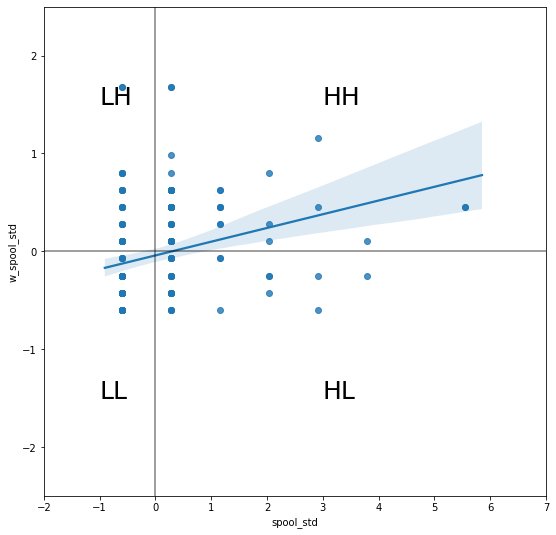

In [16]:
##codecell_Spatial_Statistical_Analysis_PLOTMoransI

#Here we are using similar matplotlib commands than in Lab3_StreetOrientation & Lab5_RasterLandscape 

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot values 
#command sns.regplot()allows you to plot the data/results and a linear regression model fit 
#such as our results of Moran's I 
#
sns.regplot(x='spool_std', y='w_spool_std', data=gts_spool)

# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-2, 7)
ax.set_ylim(-2.5, 2.5)

#add text within each quandrant
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)

# Display
plt.show()

**Learning a new language – Interpreting the code results**

What's the figure generated from *##codecell_Spatial_Statistical_Analysis__PLOTMoransI*  mean? 

In order to guide the interpretation of the plot, a linear fit is also included in the plot, together with confidence intervals. This line represents **the best linear fit** to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line. Because the line comes from a regression, we can also include a measure of the uncertainty about the fit in the form of confidence intervals (the shaded blue area around the line).

The plot displays a positive relationship between both variables. This is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. If we had to summarise the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space.

At the core of this is a classification of the observations in a dataset into four groups derived from the Moran Plot: high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL), and viceversa (LH). Each of these groups are typically called "quadrants"

###**Moran's I to Moran's local: LISA**###

Actually, as you may have realised, Moran's I can tell you about the complete spatial pattern so it tells you about the clustering BUT it tells us nothing about where the clusters might be !  It only tells you that the pattern is more clustered than it would be if it would be under spatial randomness. 

So why do we need Moran's I then? well you need to test the significance of your spatial analysis, i.e. that your regression is not violating your assumptions... so Moran's is a global test.

And, now, what do we do to get test the location of spatial clusters? We need a local statistic...To test this, we use the local variant of the Moran's test.

####**But are there local patterns inside the global one?**####

In [0]:
##codecell_Spatial_Statistical_Analysis_ImportUrLibraries

# get the tools for the local test
from pysal.explore.esda.moran import Moran_Local

####**Using your Moran's local**####

The local test breaks the global pattern down to **test for the presence of local clusters**. You can check at each SU whether or not it is likely (in a statistical significance sense) for it to participate in a local cluster.

*How does this work?*  Local measures consider each single observation in a dataset and operate on them (as oposed to on the overall data) as global measures do. 

<font color='magenta'> **LISAs (Local Indicators of Spatial Association)** </font>  are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work. Therefore, they are a key part of the exploratory toolset. In Python, we can calculate LISAs in a very streamlined way thanks to PySAL:

* **A positive value** for I indicates that a feature has neighboring features with similarly high or low attribute values; this feature is part of a cluster.
* **A negative value** for I indicates that a feature has neighboring features with dissimilar values; this feature is an outlier. 
* In either instance, the **p-value** for the feature must be small enough for the cluster or outlier to be considered statistically significant. 
* **Note** that the local Moran's I index (I) is a relative measure and can only be interpreted within the context of its computed z-score or p-value.

In [0]:
##codecell_Spatial_Statistical_Analysis_MoransLocal

# run the local test
lisa = Moran_Local(gts_spool['Spool'].values, gts_spool_weights)

####**Applying your Moran's local**####

All we need to pass is the <font color='magenta'> .values </font> variable of interest <font color='green'> "gts_spool['Spool']" </font>  and the spatial weights <font color='green'> "gts_spool_weights" </font>  that describes the neighborhood relations between the different observation that make up the dataset.

Looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember that we are calculating a statistic for every sigle observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. Instead, what is typically done is to create a **cluster map** that extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

All of the information needed is contained in the <font color='magenta'> lisa </font> object you have just created in *##codecell_Spatial_Statistical_Analysis_MoransLocal*. 


It is convenient to pull them out and insert them in the main data frame that we will call <font color='green'> "gts_spool" </font> as demonstrated in *##codecell_Spatial_Statistical_Analysis_MoransLocal_Significance*. 

In [19]:
##codecell_Spatial_Statistical_Analysis_MoransLocal_Significance

# Break observations into significant or not
# using .o_sim < we will set it at 95% confidence interval  
# so significant values are all the ones which are less than 5% 
gts_spool['significant'] = lisa.p_sim < 0.05

# By using .q command
# you can store the quadrant each observation belongs to:
# - the high-high, high-low, low-high, low-low 
# just as before (in ##codecell_Spatial_Statistical_Analysis_PLOTMoransI) are quads 1-4 
gts_spool['quadrant'] = lisa.q


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


**Learning a new language – Interpreting the code results**

 First, the <font color='magenta'> 'significance'</font> column. As with global Moran's I, PySAL is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Since we have been working with a 95% confidence interval, we select 5% using <font color='magenta'> p.sim< </font> as the threshold for statistical significance (just like with global Moran's I). 

To identify these values, we create in *##codecell_Spatial_Statistical_Analysis_MoransLocal_SignificanceResults* below a variable, significant, that contains :
 * **True** if the p-value of the observation is satisfies the condition, and 
 * **False** otherwise.

In [20]:
##codecell_Spatial_Statistical_Analysis_MoransLocal_SignificancereadingUrResults

gts_spool['significant'][:20]
# true means it is in a cluster, false means it is not

0     False
4     False
6     False
8      True
11    False
20    False
36    False
37    False
38    False
39     True
41    False
42    False
44    False
47     True
48     True
60     True
61    False
64    False
66     True
67    False
Name: significant, dtype: bool

In [21]:
##codecell_Spatial_Statistical_Analysis_MoransLocal_SignificancereadingUrResults

# You can read out the calculated p values for each 
lisa.p_sim[:20]

array([0.362, 0.058, 0.064, 0.047, 0.349, 0.062, 0.062, 0.365, 0.059,
       0.001, 0.403, 0.361, 0.271, 0.001, 0.001, 0.001, 0.341, 0.287,
       0.001, 0.052])

####**Bringing your Moran's local to your dataset**####

In [22]:
##codecell_Spatial_Statistical_Analysis_AddingUrMoransLocal2Gabiidataset

#add this info back onto the spatial data
gabii_spool_lisa = gabii.merge(gts_spool, on='SU')
gabii_spool_lisa.head()

,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry,Spool,gts_spool_weights,spool_std,w_spool_std,significant,quadrant
0,DEP,{33BC7316-B87A-4FAD-B117-043B1B72927E},0.0,None,None,2258,0,0,33.824963,42.657425,"POLYGON Z ((2330865.519 4639860.941 61.348, 23...",1.0,0.8,0.277424,0.101860,False,1
1,DEP,{9322E5A4-3B71-4E18-A8D3-61067000D37A},0.0,survey innacuracy circa 4cm,None,516,0,0,29.108417,24.196861,"POLYGON Z ((2330791.518 4639855.147 64.693, 23...",1.0,0.2,0.277424,-0.424831,False,4
2,DEP,{14B94C91-950D-4F3F-8CB0-A3D3CF196FCE},0.0,None,None,587,0,0,31.845889,35.011648,"POLYGON Z ((2330786.540 4639851.471 64.633, 23...",0.0,0.2,-0.600394,-0.424831,False,3
3,DEP,{34DFB891-ECF7-477A-939D-87491FA05165},0.0,None,None,1306,0,0,26.189290,11.969015,"POLYGON Z ((2330807.058 4639840.405 63.413, 23...",1.0,0.2,0.277424,-0.424831,True,4
4,DEP,{9CBC09F7-DBBF-4F8E-A6F9-278240E34672},0.0,None,None,1327,0,0,39.322690,67.846039,"POLYGON Z ((2330807.254 4639825.210 63.122, 23...",0.0,0.4,-0.600394,-0.249267,False,3


#####**Let's plot your Moran's Local**#########

Now we have these elements, the <font color='magenta'> signifigance </font>  and <font color='magenta'> quadrant </font>, we can make a map showing which quadrant each SU belongs to, essentially a display of where the local clusters are located.

**Parameters** are for:
* High-high = 4
* Low-low = 2

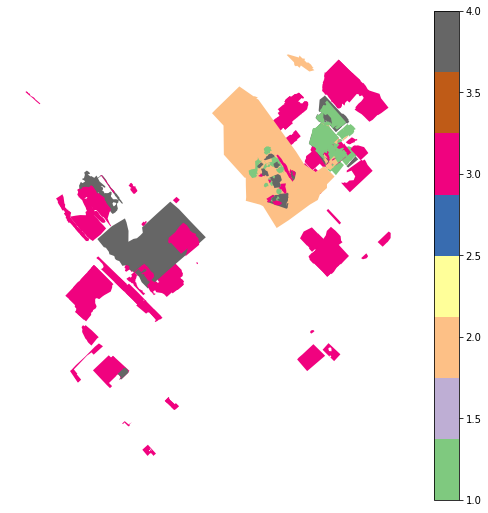

In [23]:
##codecell_Spatial_Statistical_Analysis_MappingGabiiMoransLocal

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot baseline su poly
gabii_spool_lisa.plot(column='quadrant',  ax=ax, \
        cmap='Accent', legend=True, linewidth=3)

ax.set_axis_off()
plt.axis('equal')
plt.show()

#####**Interpreting your Moran's Local**#########

How would you interpret the results of this analysis?

###**From Vector to Raster**###

You can run similar spatial statistics on raster data to understand trends and distributions of data. 

It is possible to convert point vector data to raster data via the process of interpolation. 

<font color='orangered'> ~ déjà vu ~</font> We have talked about this before:
* in *Lab2_webmaps&distributions* when presenting type of data distribution and example of applications; and,
* in *Lab5_raster_landscape* when working with DEMs, you remember rasters with an elevation attribute which was interpolated to create a surface.

<div><img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/Lab6_Interpolation_.png?raw=1" width="400"/></div>

There are many ways to interpolate data, which you can read about on this [site](https://www.neonscience.org/spatial-interpolation-basics). 

*Examples of Applications*
<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/Examples%20of%20applications.png?raw=1" width="700"/> </div> 



####**Whitebox is an open source GIS**####
<font color='magenta'> **Whitebox** </font> is full of hundreds (412 for version 1.0.2!) of useful spatial tools. 

You can download it and run it standalone (without installing!) or you can call its functions from the jupyter notebook. 

It will be well worth checking out for your own independent projects. Read about [Whitebox Tools](https://github.com/jblindsay/whitebox-tools)

In [24]:
##codecell_Spatial_Statistical_Analysis_InstallUrLibraries

# we're going to use the whitebox tools to interpolate our data and imageio to view it
!pip install whitebox # acts as a spatial toolbox
!pip install imageio 
!pip install imageio tifffile # stores numpy arrays in TIFF format files & read image&metadata from TIFFs 

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for whitebox: filename=whitebox-1.0.2-py2.py3-none-any.whl size=55297 sha256=8e41ab38d1b33d1128710bc39e73b29cb1eb494a7f5b3bd59d70047653bb2193
  Stored in directory: /root/.cache/pip/wheels/f6/80/30/bd4dad45f047587903497c274090b7a17a838c7afdee5d07dc
Successfully built whitebox
     |████████████████████████████████| 133kB 2.8MB/s 


In [25]:
##codecell_Spatial_Statistical_Analysis_ImportUrLibraries

# import your tools and print the version to check it worked

import pkg_resources # provides runtime facilities for finding, introspecting, activating and using installed Python distributions
import whitebox #advanced geospatial data analysis platform. Well you need its toolbox for that (see 3 codeline down)!
import imageio # provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats
import IPython # for displaying html outputs
import os

wbt = whitebox.WhiteboxTools()
print(wbt.version())
print(wbt.help())

Decompressing WhiteboxTools_linux_amd64.tar.xz ...
WhiteboxTools package directory: /usr/local/lib/python3.6/dist-packages/whitebox
WhiteboxTools v1.0.2 by Dr. John B. Lindsay (c) 2017-2019

WhiteboxTools is an advanced geospatial data analysis platform developed at
the University of Guelph's Geomorphometry and Hydrogeomatics Research 
Group (GHRG). See https://jblindsay.github.io/ghrg/WhiteboxTools/index.html
for more details.

WhiteboxTools Help

The following commands are recognized:
--cd, --wd       Changes the working directory; used in conjunction with --run flag.
-h, --help       Prints help information.
-l, --license    Prints the whitebox-tools license.
--listtools      Lists all available tools. Keywords may also be used, --listtools slope.
-r, --run        Runs a tool; used in conjuction with --wd flag; -r="LidarInfo".
--toolbox        Prints the toolbox associated with a tool; --toolbox=Slope.
--toolhelp       Prints the help associated with a tool; --toolhelp="LidarInfo".


In [0]:
##codecell_Spatial_Statistical_Analysis_CheckUrNewSpatialToolbox

# when there are lots of tools, it's useful to call their help info to find out what the parameters are
print(wbt.tool_help("IdwInterpolation"))

#####**Let's interpolate**#####

In [26]:
##codecell_Spatial_Statistical_Analysis_PrepareUrData

# To interpolate, as you may have noticed in your reading, we need points rather than polygons. 
# To have points, we get the center of each polygon, called centroids. 

# In these lines we essentially strip out the geometry information when we get the center of each polygon. 
spool_centroids = gabii_spool_lisa.geometry.centroid
spoolgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(spool_centroids))

#Then we 'merge' to glue the attributes we are interested in interpolating back on to our data.
spool_centroids_attr = spoolgdf.merge(gabii_spool_lisa.spool_std,right_index=True,left_index=True)

#Let's have a sneaky peek at the dataframe
spool_centroids_attr.head()

,geometry,spool_std
0,POINT (2330869.075 4639864.874),0.277424
1,POINT (2330793.781 4639851.471),0.277424
2,POINT (2330790.652 4639850.236),-0.600394
3,POINT (2330802.104 4639837.138),0.277424
4,POINT (2330813.285 4639825.847),-0.600394


#####**Let's get our working directory sorted**#####

In [27]:
##codecell_Spatial_Statistical_Analysis_SetUrWorkingDirectory

# to work in whitebox effectively, we put this data out to a temporary shapefile
# we also set a data directory where we can put this file
data_dir = '/usr/local/lib/python3.6/dist-packages/whitebox/testdata/'
wbt.set_working_dir('data_dir')
print(data_dir)

#wbt.verbose command allows you to decide if you want output messages such as warnings, progress updates and other notifications
wbt.verbose = True

#Let's place our shapefile in a file 
gabii_spool_shapes = spool_centroids_attr.to_file("/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.shp")


/usr/local/lib/python3.6/dist-packages/whitebox/testdata/


./whitebox_tools --run="IdwInterpolation" --wd="data_dir" --input='/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.shp' --field='spool_std' --output='/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif' --weight=2.0 --radius='5' --min_points='3' --cell_size='1' -v

*******************************
* Welcome to IdwInterpolation *
*******************************
Reading data...
Creating search structure: 0%
Creating search structure: 1%
Creating search structure: 2%
Creating search structure: 3%
Creating search structure: 4%
Creating search structure: 5%
Creating search structure: 6%
Creating search structure: 7%
Creating search structure: 8%
Creating search structure: 9%
Creating search structure: 10%
Creating search structure: 11%
Creating search structure: 12%
Creating search structure: 13%
Creating search structure: 14%
Creating search structure: 15%
Creating search structure: 16%
Creating search structure: 17%
Creating search structure: 18%
C

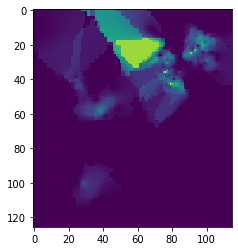

In [28]:
##codecell_Spatial_Statistical_Analysis_InterpolateRaster

# now we interpolate our centriods using the standardised spool weights and show the result
# note you can play around with the interpolation parameters to have different kernel sizes and cell sizes...

wbt.idw_interpolation(
    i="/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.shp", 
    field="spool_std",
    output="/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif", 
    use_z=False, 
    weight=2.0, 
    radius=5, 
    min_points=3, 
    cell_size=1, 
    base=None
)

raster = imageio.imread("/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif")
plt.imshow(raster)
plt.show()

In [29]:
#List data under the data folder
print(os.listdir('testdata'))

['DEM.tif', 'gabii_spool.dbf', 'gabii_spool.cpg', 'DEM.dep', 'gabii_spool.tif', 'gabii_spool.shp', 'gabii_spool.shx']


#####**Let's get the spatial statistical Analysis running**##

Now you can calculate statistics on this dataset, for example using **rasterio** like we did last week, or using **whitebox's tools**.




######**Let's check distribution**########
For example, you can check to see if the data forms a normal distribution. This lets you know what kinds of statistical tests will be valid. As we discussed last week, often archaeological distributions are not normal.

In [30]:
##codecell_Spatial_Statistical_Analysis_RasterSpatialStats_normality

wbt.ks_test_for_normality(
    "/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif", 
    "/usr/local/lib/python3.6/dist-packages/whitebox/testdata/normal.html", 
    num_samples=None
)

./whitebox_tools --run="KsTestForNormality" --wd="data_dir" --input='/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif' --output='/usr/local/lib/python3.6/dist-packages/whitebox/testdata/normal.html' -v

*********************************
* Welcome to KsTestForNormality *
*********************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress:

0

In [31]:
##codecell_Spatial_Statistical_Analysis_RasterSpatialStats_ViewNormality

# view your results
IPython.display.HTML(filename="/usr/local/lib/python3.6/dist-packages/whitebox/testdata/normal.html")

######**Let's check for autocorrelation**########


You can also run a similar autocorrelation test to the LISA one we ran above with the vector data.


In [32]:
##codecell_Spatial_Statistical_Analysis_RasterSpatialStats_Autocorrelation

wbt.image_autocorrelation(
    " /usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif", 
    "/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_autocorr.html", 
    contiguity="Rook"
)

./whitebox_tools --run="ImageAutocorrelation" --wd="data_dir" --inputs=' /usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif' --contiguity=Rook --output='/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_autocorr.html' -v

***********************************
* Welcome to ImageAutocorrelation *
***********************************
Calculating image averages...
Progress (Loop 1 of 2): 0%
Progress (Loop 1 of 2): 100%
Progress (Loop 2 of 2): 0%
Progress (Loop 2 of 2): 1%
Progress (Loop 2 of 2): 2%
Progress (Loop 2 of 2): 3%
Progress (Loop 2 of 2): 4%
Progress (Loop 2 of 2): 5%
Progress (Loop 2 of 2): 6%
Progress (Loop 2 of 2): 7%
Progress (Loop 2 of 2): 8%
Progress (Loop 2 of 2): 9%
Progress (Loop 2 of 2): 10%
Progress (Loop 2 of 2): 11%
Progress (Loop 2 of 2): 12%
Progress (Loop 2 of 2): 13%
Progress (Loop 2 of 2): 14%
Progress (Loop 2 of 2): 15%
Progress (Loop 2 of 2): 16%
Progress (Loop 2 of 2): 17%
Progress (Loop 2 of 2): 18%
Progress (Loop 2 of 2): 19%

0

In [33]:
##codecell_Spatial_Statistical_Analysis_RasterSpatialStats_ViewAutocorrelation

# view your results
IPython.display.HTML(filename='/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_autocorr.html')

This exercise ends here. Hopefully you've learned that there are statistical tests for spatial patterns and that these let us go beyond 'just visualising' to look for patterns. These tests can be run on either vector or raster data.

Clearly there's a lot to learn and explore in the world of spatial stats...

#**LexiCode**#
To re-use the codes - you will need to first load their respective libraries.  So far, you have used ...:

<br>

>libraries 	|	 	|	 	|
>--- 	|	--- 	|	 --- 	|
>[folium](https://python-visualization.github.io/folium/) 	|	 [numpy](https://numpy.org/)  	|	 [rasterio](https://rasterio.readthedocs.io/en/stable/quickstart.html)	|
>[branca](https://pypi.org/project/branca/)	|	 [rtree](https://pypi.org/project/Rtree/) 	|	 [richdem](https://richdem.readthedocs.io/en/latest/)	|
>[pandas](https://pandas.pydata.org/)	|	 [osmnx](https://osmnx.readthedocs.io/en/stable/)	|	 [elevation](https://pypi.org/project/elevation/)	|
>[geopandas](http://geopandas.org/)	|	 [requests](https://realpython.com/python-requests/) 	|	 [zipfile](https://docs.python.org/3/library/zipfile.html) 	|
>[seaborn](https://seaborn.pydata.org/index.html) 	|	 [fiona](https://pypi.org/project/Fiona/)	|	 [io](https://docs.python.org/3/library/io.html#overview) 	|
>[matplotlib.pyplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html) 	|	 [ipywidgets](https://github.com/jupyter-widgets/ipywidgets)	|	[seaborn](https://seaborn.pydata.org/) 	|
> [pysal](https://pysal.readthedocs.io/en/v1.11.0/users/introduction.html) 	|	 [os](https://docs.python.org/3/library/os.html)	|	[gdal](https://gdal.org/)	|
>  [pkg_resources](https://setuptools.readthedocs.io/en/latest/pkg_resources.html#overview)	|	[whitebox](https://jblindsay.github.io/wbt_book/intro.html) 	|	[imageio](https://pypi.org/project/imageio/) 	|
> [IPython](https://ipython.org/)	|	[imageio tifffile](https://pypi.org/project/tifffile/)	|		|


<br>


 plugins| |
--- |--- |
HeatMapWithTime 
HeatMap
MeasureControl
PrepareUrBasemaps_CreateLayers from [folium.plugins]
cluster (from sklearn)
rasterio.plot
mapping (from shapely.geometry)
Point(from shapely.geometry)  
mask (from rasterio.mask) 
Moran  (from pysal.explore.esda.moran) 
Moran_Local (from pysal.explore.esda.moran) 

<br>

At this point you have learned so many thigs that the lexicode is non-exhaustive. It might be useful to make your own custum 'lexicode' with the commands you use the most often.

<br>

>Lexicode_MakingaBasicMap 	|	 Lexicode_Webmaps&Distributions 	|	Lexicode_StreetGridOrientations 	|	 Lexicode_SpatialPatterns 	|	 Lexicode_RasterLandscape 	|	 Lexicode_Pysal_weights_Moran_Lisa	|
>--- 	|	 --- 	|	 ---	|	---	|	----	|	---	|
> ==   () [] 	|	 pd.concat() 	|	 { } *subselection from list*	|	%matplotlib inline  	|	 .open()	|	.tail()	|
>.head_csv() 	|	 .dtype() 	|	 ox.gdf_from_places()	|	requests.get()	|	.print()	|	ax.set_axis_off()	|
>.read_csv() 	|	 astype() 	|	 ox.plot_shape()	|	request.content()	|	dataset.name	|	f.set_facecolor	|
>mean()  	|	 fillna()	|	network_type= ''	|	.bytes()	|	dataset.count	|	plt.axis	|
>folium.Map 	|	 def return 	|	ox.add_edge_bearings(ox.get_undirected())	|	gpd.GeoDataFrame.from_features()	|	dataset.shape	|	f.suptitle()	|
>range() 	|	 .apply(lambda x:*function*,axis=) 	|	count_and_merge()	|	Set()	|	dataset.descriptions	|	f.set_facecolor	|
>len() 	|	 pd.merge() 	|	np.arrange()	|	pd.value_counts() 	|	dataset.meta	|	plt.axis	|
>iloc[]	|	 how= , left_index= ,left_index= 	|	np.histogram()	|	.merge()	|	dataset.driver	|	f.suptitle()	|
>.value_counts()	|	 gpd.GeoDataFrame()	|	 ax.set_theta_location()	|	.sort_values	|	dataset.read	|	.remap_ids	|
>if =:	|	 geometry=gpd.points_from_xy 	|	ax.set_ylim()	|	cluster.KMeans()	|	.shape	|	.transform	|
>elif =: 	|	print() 	|	ax.set_title()	|	.fit()	|	np.amean()	|	lag_spatial()	|
>else =:	|	 .isin()	|	ax.set_yticks()	|	.drop() 	|	np.amin ()	|	.mean()	|
>folium.Marker()	|	 classic.plot()	|	ax.set_xlabels() & ax.set_yticklabels	|	.assign()	|	np.amax()	|	.std()	|
>folium.Icon()	|	 generateBaseMap()	|	plt.subplots()	|	plt.show()	|	np.std()	|	sns.regplot()	|
>folium.Circle	|	 .groupby(['', ''])	|	.dropna()	|	.set_title	|	show()	|	Moran_local	|
>popup= 	|	 .reset_index() 	|	polar_plot()	|	sns.pairplot()	|	cmap=	|	p.sim()	|
>radius= 	|	  max_zoom= 	|	pd.Series()	|	arrs.append()	|	np.seterr()	|	Lisa.q	|
>.values.tolist() 	|	folium.TileLayer()	|	np.pi	|	.show_hist()	|	[plt.imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html)	|	wbt.set_working_dir()	|
>.add_to()	|	 plugins.DualMap(location= , tiles= , zoom_start= )	|	 	|	 	|	clipped_img	|	wbt.verbose()	|
> 	|	 	|	 	|	 	|	rd.TerrainAttribute()	|	.to_file(" ")	|
>  	|	 	|	 	|	 	|	rdShow() 	|	wbt.idw_interpolation()	|
>  	|	 	|	 	|	 	|	gdal_data.GetRasterBand()	|	imageio.imread(os.path.join())	|
>  	|	 	|	 	|	 	|	gdal_band.GetNoDataValue()	|	wbt.ks_test_for_normality()	|
>  	|	 	|	 	|	 	|	gdal_data.ReadAsArray	|	IPython.display.HTML()	|
>  	|	 	|	 	|	 	|	gdal_data.ReadAsArray().astype(np.float)	|	wbt.image_autocorrelation()	|
>  	|	 	|	 	|	 	|	plt.contour()	|		|
>  	|	 	|	 	|	 	|	plt.contourf()	|		|


